In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/diagnosis-of-diabetic-retinopathy")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [97]:
from transformers import ViTForImageClassification
from torch.optim import AdamW
from datasets import load_dataset
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as F
import os
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import torch.optim as optim
sns.set()

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])

In [21]:
os.listdir('/kaggle/input/')

['Diagnosis of Diabetic Retinopathy', 'retino']

In [22]:
os.listdir('/kaggle/input/Diagnosis of Diabetic Retinopathy')

['valid', 'test', 'train']

In [23]:
train_dir = '/kaggle/input/Diagnosis of Diabetic Retinopathy/train'
test_dir = '/kaggle/input/Diagnosis of Diabetic Retinopathy/test'
valid_dir = '/kaggle/input/Diagnosis of Diabetic Retinopathy/valid'

In [24]:
train_dataset = datasets.ImageFolder(train_dir, transform = transform)
test_dataset = datasets.ImageFolder(test_dir, transform = transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform = transform)

In [110]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False, num_workers = 4)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle = False, num_workers = 4)

In [26]:
num_classes = len(train_dataset.classes)
print(num_classes)

2


In [27]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [28]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels = num_classes
).to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
    elif 'encoder.layer' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [30]:
optimizer = torch.optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'classifier' in n], 'lr': 1e-4},
    {'params': [p for n, p in model.named_parameters() if 'encoder' in n], 'lr': 3e-5}
], weight_decay=0.01)

In [31]:
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [32]:
def plot_results(train_accs, train_losses, valid_accs, valid_losses):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_accs, label = 'Train')
    axes[0].plot(xs, valid_accs, label = 'Validation')
    axes[0].set_title('Training Loss vs Validation Accuracy', fontsize = 15)
    axes[0].set_xlabel('Epochs', fontsize = 10)
    axes[0].set_ylabel('Accuracy', fontsize = 10)
    axes[0].set_xticks(xs)
    axes[0].legend()
    axes[1].plot(xs, train_losses, label = 'Train')
    axes[1].plot(xs, valid_losses, label = 'Validation')
    axes[1].set_title('Training Loss vs Validation Loss', fontsize = 15)
    axes[1].set_xlabel('Epochs', fontsize = 10)
    axes[1].set_ylabel('Loss', fontsize = 10)
    axes[1].set_xticks(xs)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [33]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in dataloader:
        images, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        preds = model(images).logits
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (preds.argmax(dim=1) == labels).sum().item()
    return train_loss / len(dataloader), 100 * train_acc / len(dataloader.dataset)

In [34]:
def valid_step(model, criterion, dataloader, device = device):
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images).logits
            valid_loss += criterion(preds, labels).item()
            valid_acc += (preds.argmax(dim=1) == labels).sum().item()
        return valid_loss / len(dataloader), 100 * valid_acc / len(dataloader.dataset)

In [35]:
def train_model(model, num_epochs, optimizer, train_loader, valid_loader, device = device):
    train_accs = []
    train_losses = []
    valid_accs = []
    valid_losses = []
    criterion = torch.nn.CrossEntropyLoss()
    pbar = trange(num_epochs)
    for epoch in pbar:
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = valid_step(model, criterion, valid_loader, device)
        scheduler.step()
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc:.3f}')
    plot_results(train_accs, train_losses, valid_accs, valid_losses)
    return {'train_acc': train_acc, 'train_loss': train_loss, 'valid_acc': valid_acc, 'valid_loss': valid_loss}

Train Loss: 0.023 | Train Acc: 99.422 | valid Loss: 0.065 | Valid Acc: 97.740: 100%|██████████| 10/10 [13:54<00:00, 83.44s/it]


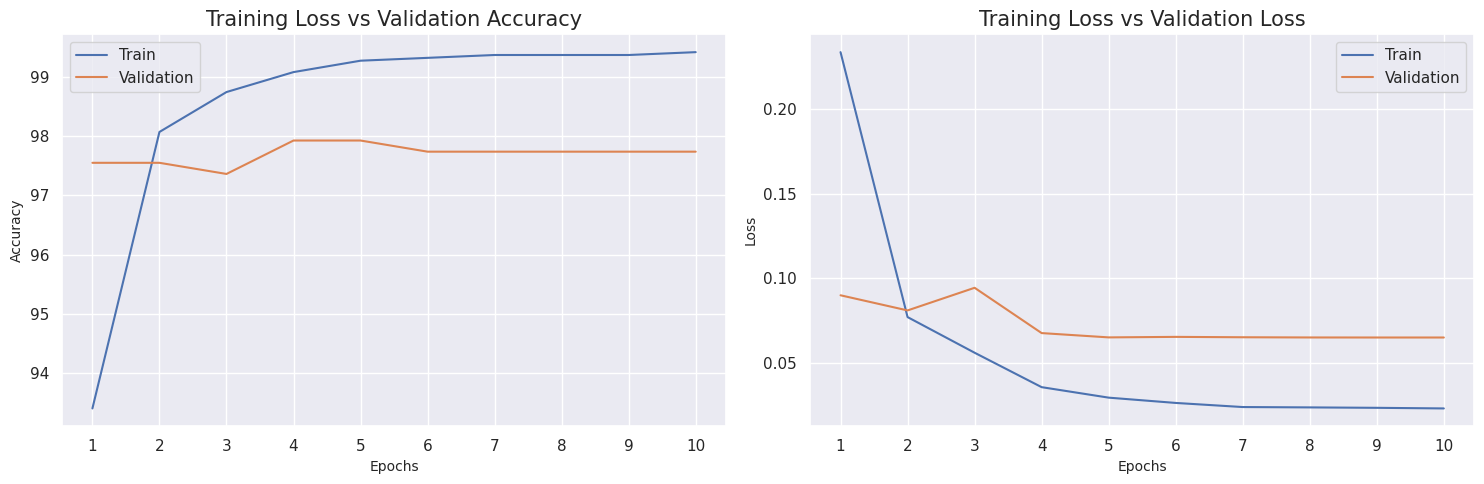

In [36]:
results = train_model(model, 10, optimizer, train_loader, valid_loader, device = device)

In [37]:
criterion = torch.nn.CrossEntropyLoss()

In [38]:
test_loss, test_acc = valid_step(model, criterion, test_loader, device = device)

In [39]:
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.3f}')

Test Loss: 0.072 | Test Accuracy: 98.268


In [40]:
def test_confusion_matrix(model, criterion, dataloader, device = device):
    model.eval()
    total_labels = []
    total_preds = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())
    cm = sk_confusion_matrix(total_labels, total_preds)
    plt.figure(figsize = (7, 5))
    sns.heatmap(cm, annot = True, cbar = True, square = True, annot_kws = {'size': 15}, fmt = 'd', cmap = 'Blues')
    plt.title('Confusion Matrix', fontsize = 15)
    plt.xlabel('Predicted', fontsize = 10)
    plt.ylabel('Truth', fontsize = 10)
    plt.show()

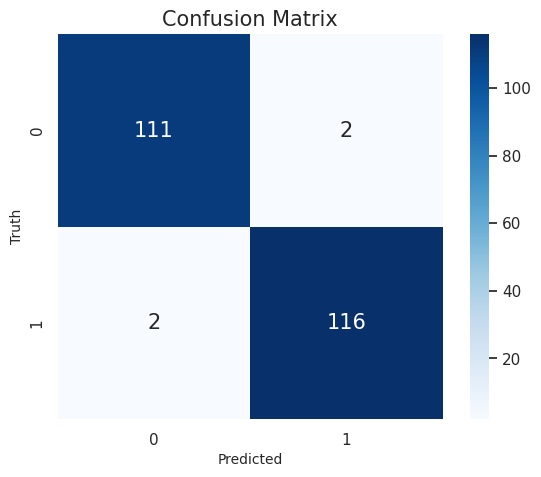

In [41]:
test_confusion_matrix(model, criterion, test_loader, device = device)